# Árvore para atributos discretos

In [21]:
from sklearn.datasets import load_iris
dataset = load_iris()
X = dataset.data[:, -2:]
feature_names = dataset.feature_names[-2:]
y = dataset.target
labels = dataset.target_names
X.shape, y.shape

((150, 2), (150,))

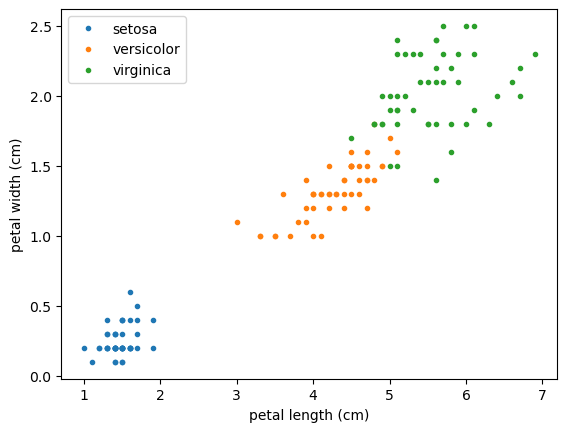

In [22]:
import matplotlib.pyplot as plt

for i in range(len(set(y))):
    plt.plot(X[y==i, 0], X[y==i, 1], ".", label=labels[i])
plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])
plt.legend()
plt.show()

In [49]:
import matplotlib.pyplot as plt
import numpy as np

def plotDecisao(modelo, X, y):
    modelo.fit(X, y)
    x0s = np.linspace(np.min(X[:,0])-0.2, np.max(X[:,0])+0.2, 100)
    x1s = np.linspace(np.min(X[:,1])-0.2, np.max(X[:,1])+0.2, 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    Xdec = np.c_[x0.ravel(), x1.ravel()]
    ypred = modelo.predict(Xdec)
    
    plt.title(str(modelo.__class__.__name__))
    plt.contourf(x0, x1, ypred.reshape(x0.shape), alpha=0.25)
    for k in set(y):
        plt.plot(X[:,0][y==k], X[:,1][y==k], 'o', label=f"{labels[k]} [{k}]")
    plt.xlabel(f"X[0]: {feature_names[0]}")
    plt.ylabel(f"X[1]: {feature_names[1]}")
    plt.show()

# Heuristica p/ Arvores (Básica) - Aula

Accuracy Score ArvoreBasica 0.9533333333333334
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True False  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
 False  True  True  True  True False  True  True  True  True  True False
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True False  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True False  True  True  True  True  True
  True  True  True  True  True  True False  True  True  True  True  True
  True  True  True  True  True  True]


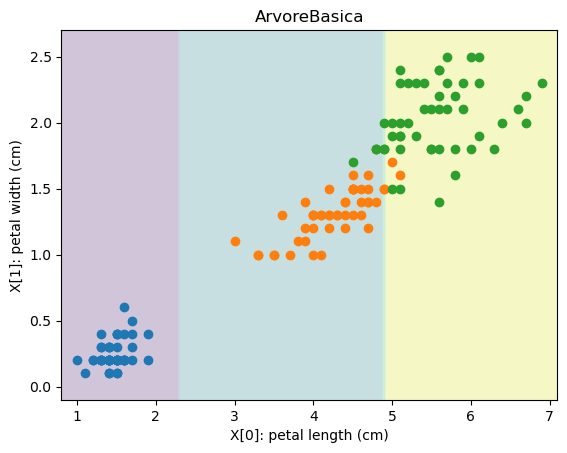

In [51]:
from sklearn.metrics import accuracy_score
import numpy as np
from collections import Counter
from sklearn.base import BaseEstimator, ClassifierMixin

def maisFrequente(y):
    return Counter(y.flat).most_common(1)[0][0]

class ArvoreBasica(BaseEstimator, ClassifierMixin):
    def __init__(self):
        self.caracteristica = 0
    def fit(self, X, y):
        self.valor = np.mean(X[:,self.caracteristica])
        maiores = X[:,self.caracteristica] > self.valor
        if sum(maiores)>0 and sum(~maiores)>0:
            self.maiores = self.__class__()
            self.maiores.fit(X[maiores,:],y[maiores])
            self.menores = self.__class__()
            self.menores.fit(X[~maiores,:],y[~maiores])
        else:
            self.resposta = maisFrequente(y)
    def predict(self, X):
        y = np.empty((X.shape[0]))
        if hasattr(self, 'resposta'):
            y[:] = self.resposta
        else:
            maiores = X[:,self.caracteristica] > self.valor
            y[maiores] = self.maiores.predict(X[maiores,:])
            y[~maiores] = self.menores.predict(X[~maiores,:])
        return y

model = ArvoreBasica()
model.fit(X,y)
y_pred = model.predict(X)
print(f"Accuracy Score {model.__class__.__name__}", accuracy_score(y, y_pred))
print((y_pred == y))

plotDecisao(ArvoreBasica(), X, y)

# Heuristica p/ Arvores (Avançada) - Aula

In [83]:
def impureza(y): #Gini
    labels = list(set(y))
    labels.sort()
    probabilidades = np.zeros((len(labels),))
    for i,k in enumerate(labels):
        probabilidades[i] = sum(y==k)/len(y)
    result = 1 - sum(probabilidades**2)
    return result


def impurezaValor(x, y, valor):
    maiores = x>valor
    impurezaMaiores = impureza(y[maiores])
    propMaiores = sum(maiores)/len(y)
    impurezaMenores = impureza(y[~maiores])
    propMenores = sum(~maiores)/len(y)
    impurezaTotal = propMaiores*impurezaMaiores + propMenores*impurezaMenores
    return impurezaTotal, impurezaMaiores, impurezaMenores


def melhorValor(x, y):
    result = None
    menorImpureza = float('inf')
    xmax = np.max(x)
    xmin = np.min(x)
    while True:
        valor = (xmin+xmax)/2
        #print(valor)
        impTotal, impMaiores, impMenores = impurezaValor(x, y, valor)
        if impTotal < menorImpureza:
            menorImpureza = impTotal
            result = valor
            if impMaiores == 0 or impMenores == 0:
                break
            if impMaiores < impMenores:
                xmin = valor
            else:
                xmax = valor
        else:
            break
    return result, menorImpureza


def melhorCaracteristica(X, y):
    impurezas = []
    valores = []
    for caracteristica in range(X.shape[1]):
        valor, imp = melhorValor(X[:,caracteristica], y)
        impurezas.append(imp)
        valores.append(valor)
    impurezas = np.array(impurezas)
    caracteristica = np.argmin(impurezas)
    return caracteristica, valores[caracteristica], impurezas[caracteristica]


ytmp = y[:]
print("Impureza:", impureza(ytmp))
print("Impureza Valor:", impurezaValor(X[:,0], y, 2.5)    )
print("Melhor Valor:", melhorValor(X[:,0], y))
print("Melhor Caracteristica:", melhorCaracteristica(X,y))

Impureza: 0.6583133442747129
Impureza Valor: (0.6583133442747129, 0.6583133442747129, 1)
Melhor Valor: (12.93, 0.47001468529080287)
Melhor Caracteristica: (12, 979.0, 0.43761750381193476)


Accuracy Score ArvoreAvancada 0.9933333333333333
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True False  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]


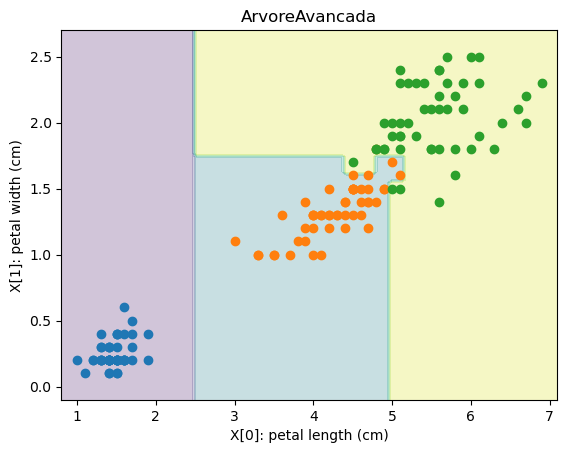

In [58]:
from sklearn.metrics import accuracy_score
import numpy as np
from collections import Counter
from sklearn.base import BaseEstimator, ClassifierMixin

def maisFrequente(y):
    return Counter(y.flat).most_common(1)[0][0]

class ArvoreAvancada(BaseEstimator, ClassifierMixin):
    def fit(self, X, y):
        self.caracteristica, self.valor, self.imp = melhorCaracteristica(X,y)
        maiores = X[:,self.caracteristica] > self.valor
        if sum(maiores)>0 and sum(~maiores)>0:
            self.maiores = self.__class__()
            self.maiores.fit(X[maiores,:],y[maiores])
            self.menores = self.__class__()
            self.menores.fit(X[~maiores,:],y[~maiores])
        else:
            self.resposta = maisFrequente(y)
    def predict(self, X):
        y = np.empty((X.shape[0]))
        if hasattr(self, 'resposta'):
            y[:] = self.resposta
        else:
            maiores = X[:,self.caracteristica] > self.valor
            y[maiores] = self.maiores.predict(X[maiores,:])
            y[~maiores] = self.menores.predict(X[~maiores,:])
        return y

model = ArvoreAvancada()
model.fit(X,y)
y_pred = model.predict(X)
print(f"Accuracy Score {model.__class__.__name__}", accuracy_score(y, y_pred))
print((y_pred == y))

plotDecisao(ArvoreAvancada(), X, y)

# Decision Tree (sklearn)

Accuracy Score DecisionTreeClassifier 0.9933333333333333
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True False  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]


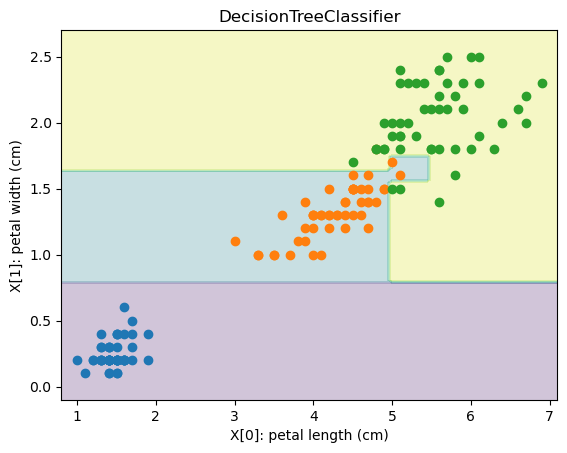

In [59]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
model.fit(X,y)
y_pred = model.predict(X)
print(f"Accuracy Score {model.__class__.__name__}", accuracy_score(y, y_pred))
print((y_pred == y))

plotDecisao(DecisionTreeClassifier(), X, y)

# Minha Heurística (Mediana dos valores)

In [61]:

def melhor_valor(x, y):
    valor = np.median(x)
    result = valor
    impTotal, impMaiores, impMenores = impurezaValor(x, y, valor)
    menorImpureza = impTotal
    while impTotal < menorImpureza:
        valor = np.median(x)
        result = valor
        impTotal, impMaiores, impMenores = impurezaValor(x, y, valor)
        menorImpureza = impTotal
        if impMaiores == 0 or impMenores == 0:
            break
    return result, menorImpureza


def minha_heuristica(X, y):
    impurezas = []
    valores = []
    for caracteristica in range(X.shape[1]):
        valor, imp = melhor_valor(X[:,caracteristica], y)
        impurezas.append(imp)
        valores.append(valor)
    impurezas = np.array(impurezas)
    caracteristica = np.argmin(impurezas)
    return caracteristica, valores[caracteristica], impurezas[caracteristica]


ytmp = y[:]
print("Impureza:", impureza(ytmp))
print("Impureza Valor:", impurezaValor(X[:,0], y, 2.5)    )

print()
print("Melhor Valor v1:", melhorValor(X[:, 0], y))
print("Melhor Caracteristica:", melhorCaracteristica(X, y))
print()

print("Melhor Valor v2:", melhor_valor(X[:,0], y))
print("Minha Heuristica:", minha_heuristica(X,y))

Impureza: 0.6666666666666667
Impureza Valor: (0.3333333333333333, 0.5, 0.0)

Melhor Valor v1: (2.475, 0.3333333333333333)
Melhor Caracteristica: (0, 2.475, 0.3333333333333333)

Melhor Valor v2: (4.35, 0.4444444444444444)
Minha Heuristica: (1, 1.3, 0.44301994301994296)


Accuracy Score MinhaArvore 0.9933333333333333
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True False  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]


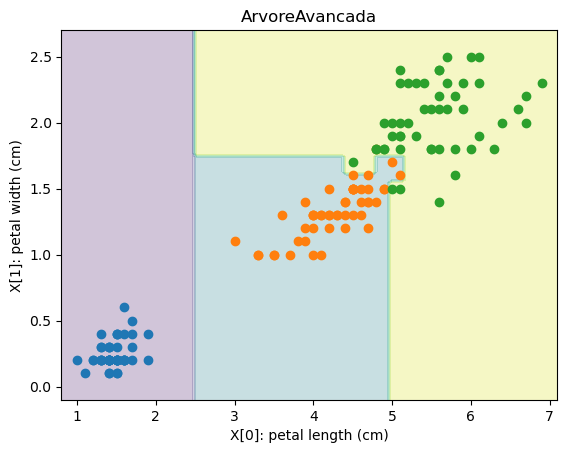

In [62]:
from sklearn.metrics import accuracy_score
import numpy as np
from collections import Counter
from sklearn.base import BaseEstimator, ClassifierMixin

def maisFrequente(y):
    return Counter(y.flat).most_common(1)[0][0]

class MinhaArvore(BaseEstimator, ClassifierMixin):
    def fit(self, X, y):
        self.caracteristica, self.valor, self.imp = minha_heuristica(X,y)
        maiores = X[:,self.caracteristica] > self.valor
        if sum(maiores)>0 and sum(~maiores)>0:
            self.maiores = self.__class__()
            self.maiores.fit(X[maiores,:],y[maiores])
            self.menores = self.__class__()
            self.menores.fit(X[~maiores,:],y[~maiores])
        else:
            self.resposta = maisFrequente(y)
    def predict(self, X):
        y = np.empty((X.shape[0]))
        if hasattr(self, 'resposta'):
            y[:] = self.resposta
        else:
            maiores = X[:,self.caracteristica] > self.valor
            y[maiores] = self.maiores.predict(X[maiores,:])
            y[~maiores] = self.menores.predict(X[~maiores,:])
        return y

model = MinhaArvore()
model.fit(X,y)
y_pred = model.predict(X)
print(f"Accuracy Score {model.__class__.__name__}", accuracy_score(y, y_pred))
print((y_pred == y))

plotDecisao(ArvoreAvancada(), X, y)

# Cross Validate Iris

In [70]:
from sklearn.model_selection import cross_validate

for model in [ArvoreBasica(), ArvoreAvancada(), MinhaArvore(), DecisionTreeClassifier()]:
    scores = cross_validate(model, X, y)
    print(f"Test Score ({model.__class__.__name__}):",scores['test_score'])
    print(f"Mean Test Score ({model.__class__.__name__}):", np.mean(scores['test_score']), '\n')

Test Score (ArvoreBasica): [0.93333333 0.93333333 0.8        0.93333333 1.        ]
Mean Test Score (ArvoreBasica): 0.9200000000000002 

Test Score (ArvoreAvancada): [0.96666667 0.96666667 0.9        0.93333333 1.        ]
Mean Test Score (ArvoreAvancada): 0.9533333333333334 

Test Score (MinhaArvore): [0.96666667 0.96666667 0.83333333 0.9        1.        ]
Mean Test Score (MinhaArvore): 0.9333333333333332 

Test Score (DecisionTreeClassifier): [0.96666667 0.96666667 0.9        0.93333333 1.        ]
Mean Test Score (DecisionTreeClassifier): 0.9533333333333334 



# Outros datasets
* Wine
* Breast Cancer
* [Penguin](https://github.com/mwaskom/seaborn-data/blob/master/penguins.csv)

In [90]:
from sklearn.datasets import load_wine, load_breast_cancer
from sklearn.model_selection import cross_validate


In [93]:
load_dataset = load_wine
# =============================================#
dataset = load_dataset()
X, y = dataset.data, dataset.target
dataset_name = ' '.join(load_dataset.__name__.split('_')[1:])
print("Dataset:", dataset_name.capitalize())
print("First Row:", X[0,:], '\n')
for model in [ArvoreBasica(), ArvoreAvancada(), MinhaArvore(), DecisionTreeClassifier()]:
    scores = cross_validate(model, X, y)
    print(f"Test Score ({model.__class__.__name__}):",scores['test_score'])
    print(f"Mean Test Score ({model.__class__.__name__}):", np.mean(scores['test_score']), '\n')

Dataset: Wine
First Row: [1.423e+01 1.710e+00 2.430e+00 1.560e+01 1.270e+02 2.800e+00 3.060e+00
 2.800e-01 2.290e+00 5.640e+00 1.040e+00 3.920e+00 1.065e+03] 

Test Score (ArvoreBasica): [0.61111111 0.55555556 0.55555556 0.51428571 0.74285714]
Mean Test Score (ArvoreBasica): 0.5958730158730159 

Test Score (ArvoreAvancada): [0.77777778 0.88888889 0.83333333 1.         0.97142857]
Mean Test Score (ArvoreAvancada): 0.8942857142857144 

Test Score (MinhaArvore): [0.72222222 0.83333333 0.88888889 0.88571429 0.91428571]
Mean Test Score (MinhaArvore): 0.8488888888888889 

Test Score (DecisionTreeClassifier): [0.91666667 0.80555556 0.86111111 0.91428571 0.85714286]
Mean Test Score (DecisionTreeClassifier): 0.8709523809523809 



In [94]:
load_dataset = load_breast_cancer
# =============================================#
X, y = load_dataset(return_X_y=True)
dataset_name = ' '.join(load_dataset.__name__.split('_')[1:])
print("Dataset:", dataset_name.capitalize())
print("First Row:", X[0,:], '\n')
for model in [ArvoreBasica(), ArvoreAvancada(), MinhaArvore(), DecisionTreeClassifier()]:
    scores = cross_validate(model, X, y)
    print(f"Test Score ({model.__class__.__name__}):",scores['test_score'])
    print(f"Mean Test Score ({model.__class__.__name__}):", np.mean(scores['test_score']), '\n')

Dataset: Breast cancer
First Row: [1.799e+01 1.038e+01 1.228e+02 1.001e+03 1.184e-01 2.776e-01 3.001e-01
 1.471e-01 2.419e-01 7.871e-02 1.095e+00 9.053e-01 8.589e+00 1.534e+02
 6.399e-03 4.904e-02 5.373e-02 1.587e-02 3.003e-02 6.193e-03 2.538e+01
 1.733e+01 1.846e+02 2.019e+03 1.622e-01 6.656e-01 7.119e-01 2.654e-01
 4.601e-01 1.189e-01] 

Test Score (ArvoreBasica): [0.78947368 0.81578947 0.81578947 0.84210526 0.81415929]
Mean Test Score (ArvoreBasica): 0.815463437354448 

Test Score (ArvoreAvancada): [0.92982456 0.86842105 0.94736842 0.93859649 0.91150442]
Mean Test Score (ArvoreAvancada): 0.9191429902189101 

Test Score (MinhaArvore): [0.92982456 0.92982456 0.96491228 0.89473684 0.92035398]
Mean Test Score (MinhaArvore): 0.927930445582984 

Test Score (DecisionTreeClassifier): [0.9122807  0.92982456 0.90350877 0.93859649 0.90265487]
Mean Test Score (DecisionTreeClassifier): 0.9173730787144854 



In [100]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

def load_penguin(return_X_y=True):
    le = LabelEncoder()
    df = pd.read_csv("https://raw.githubusercontent.com/mwaskom/seaborn-data/master/penguins.csv")
    if not return_X_y:
        return df
    df = df.dropna()
    penguin_gender = df.pop("sex")
    df = pd.concat([df, pd.get_dummies(penguin_gender)], axis=1)
    penguin_island = df.pop("island")
    df = pd.concat([df, pd.get_dummies(penguin_island)], axis=1)
    target_df = df.pop('species')
    y = target_df.values
    X = df.values
    le.fit(y)
    return X, le.transform(y)

In [101]:
load_dataset = load_penguin
# =============================================#
X, y = load_dataset(return_X_y=True)
dataset_name = ' '.join(load_dataset.__name__.split('_')[1:])
print("Dataset:", dataset_name.capitalize())
print("First Row:", X[0,:], '\n')
for model in [ArvoreBasica(), ArvoreAvancada(), MinhaArvore(), DecisionTreeClassifier()]:
    scores = cross_validate(model, X, y)
    print(f"Test Score ({model.__class__.__name__}):",scores['test_score'])
    print(f"Mean Test Score ({model.__class__.__name__}):", np.mean(scores['test_score']), '\n')

Dataset: Penguin
First Row: [3.91e+01 1.87e+01 1.81e+02 3.75e+03 0.00e+00 1.00e+00 0.00e+00 0.00e+00
 1.00e+00] 

Test Score (ArvoreBasica): [0.70149254 0.71641791 0.67164179 0.59090909 0.66666667]
Mean Test Score (ArvoreBasica): 0.6694255992763455 

Test Score (ArvoreAvancada): [1.         0.95522388 0.97014925 0.98484848 0.98484848]
Mean Test Score (ArvoreAvancada): 0.9790140208050655 

Test Score (MinhaArvore): [1.         0.98507463 0.97014925 0.98484848 0.98484848]
Mean Test Score (MinhaArvore): 0.9849841700587969 

Test Score (DecisionTreeClassifier): [1.         0.98507463 0.98507463 0.95454545 0.93939394]
Mean Test Score (DecisionTreeClassifier): 0.9728177295341475 



Os modelos `ArvoreBasica` e `ArvoreAvancada` foram modelos baseados no material da aula sobre arvores, tendo pequenas alterações para facilitar o trabalho com estas classes, enquanto o modelo `MinhaArvore` foi a minha proposta de heuristica. A principal diferença entre ele e o `ArvoreAvancada` é o uso da mediana como parametro para o melhor valor, ao invés da média entre `xmax` e `xmin`. Por fim, foi utilzado o `DecisionTreeClassifier` como modelo de benchmark do Scikit Learn.
Inicialmente foi testado o Iris dataset e foi possível observar que a heurística com melhor desempenho foram as heuristicas do `ArvoreAvancada` e `DecisionTreeClassifier`, e o pior foi a `ArvoreBasica`, porém a diferença em sí foi bem pequena, 3,3%.

Os 3 dataset selecionados foram o Wine e o Breast Cancer Dataset do Scikit Learn e o Penguin Dataset do Seaborn Data. Em todos os 3 datasets a heuristica com pior desempenho foi a `ArvoreBasica`, sendo o pior cenário no Wine Dataset, com 59,58% de score, enquanto os melhores foram o `ArvoreAvancada` no Wine Dataset com 89,42% de score e o `MinhaArvore` com um score de 92,79% no Breast Cancer Dataset e 98,49% no Penguin Dataset.